In [14]:
import torch
import pythoncom
from win32com.client import Dispatch, gencache

def get_kompas_api7():
    module = gencache.EnsureModule("{69AC2981-37C0-4379-84FD-5DD2F3C0A520}", 0, 1, 0)
    api = module.IKompasAPIObject(
        Dispatch("Kompas.Application.7")._oleobj_.QueryInterface(module.IKompasAPIObject.CLSID,
                                                                 pythoncom.IID_IDispatch))
    return module, api

def get_kompas_api5():
    module = gencache.EnsureModule("{0422828C-F174-495E-AC5D-D31014DBBE87}", 0, 1, 0)
    api = module.KompasObject(            
        Dispatch("Kompas.Application.5")._oleobj_.QueryInterface(module.KompasObject.CLSID,                                                        
                                                                 pythoncom.IID_IDispatch))   
    return module, api

def get_constants():
    const = gencache.EnsureModule("{75C9F5D0-B5B8-4526-8681-9903C567D2ED}", 0, 1, 0).constants
    const_3d = gencache.EnsureModule("{2CAF168C-7961-4B90-9DA2-701419BEEFE3}", 0, 1, 0).constants
    return const, const_3d

module7, api7 = get_kompas_api7()   # Подключаемся к API7 
module5, api5 = get_kompas_api5()   # Подключаемся к API5 
const, const_3d = get_constants()
app7 = api7.Application                     # Получаем основной интерфейс
app7.Visible = True                         # Показываем окно пользователю (если скрыто)
app7.HideMessage = const.ksHideMessageNo   # Отвечаем НЕТ на любые вопросы программы

#  Подключим константы API Компас
kompas6_constants = gencache.EnsureModule("{75C9F5D0-B5B8-4526-8681-9903C567D2ED}", 0, 1, 0).constants
kompas6_constants_3d = gencache.EnsureModule("{2CAF168C-7961-4B90-9DA2-701419BEEFE3}", 0, 1, 0).constants

#  Подключим описание интерфейсов API5
kompas6_api5_module = gencache.EnsureModule("{0422828C-F174-495E-AC5D-D31014DBBE87}", 0, 1, 0)
kompas_object = kompas6_api5_module.KompasObject(Dispatch("Kompas.Application.5")._oleobj_.QueryInterface(kompas6_api5_module.KompasObject.CLSID, pythoncom.IID_IDispatch))

#  Подключим описание интерфейсов API7
kompas_api7_module = gencache.EnsureModule("{69AC2981-37C0-4379-84FD-5DD2F3C0A520}", 0, 1, 0)
application = kompas_api7_module.IApplication(Dispatch("Kompas.Application.7")._oleobj_.QueryInterface(kompas_api7_module.IApplication.CLSID, pythoncom.IID_IDispatch))

Documents = application.Documents

In [2]:
import os
path = os.getcwd() + "\\filesK"
files = os.listdir(path)
files

['cil1.m3d',
 'cil1.m3d.bak',
 'cil2.m3d',
 'cil3.m3d',
 'cil4.m3d',
 'cil5.m3d',
 'cil6.m3d',
 'cube1.m3d',
 'cube10.m3d',
 'cube11.m3d',
 'cube2.m3d',
 'cube3.m3d',
 'cube4.m3d',
 'cube5.m3d',
 'cube6.m3d',
 'cube7.m3d',
 'cube8.m3d',
 'cube9.m3d',
 'dataset.csv',
 'trap.m3d',
 '~$cil6.m3~',
 '~$cube3.m3~']

In [4]:
filePath = path + "\\" + files[0]
filePath

'z:\\Work\\Diplom+\\filesK\\cil1.m3d'

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def model_to_graph(filePath):
    kompas_document = Documents.Open(filePath, True, False)
    # Инициализируем граф NetworkX
    G = nx.DiGraph()
    iDocument3D = api5.ActiveDocument3D()
    kompas_document_3d = module7.IKompasDocument3D(kompas_document)
    iPart7 = kompas_document_3d.TopPart
    iPart = iDocument3D.GetPart(const_3d.pTop_Part)


    faces = iPart.EntityCollection(0)

    for j in range (faces.GetCount()):
        entity = faces.GetByIndex(j)
        if entity != None:
            if entity.type == 6: # если поверхность
                entity.name = 'F_' + str(j)
            if entity.type == 7: # если ребро
                entity.name = 'E_' + str(j)
            if entity.type == 8: # если вершина
                entity.name = 'V_' + str(j)

    def get_entity(num):
        entity = faces.GetByIndex(num)
        if entity != None:
            if entity.type == 6: # если поверхность
                face = entity.GetDefinition()
                connected= face.ConnectedFaceCollection()
                # Добавляем грань как основной узел
                G.add_node(entity.name, type="face")
                for c in range(connected.GetCount()):
                    conFace = connected.GetByIndex (c)
                    if conFace.GetEntity().name == '':
                        print('!!')
                    if not G.has_edge(entity.name, conFace.GetEntity().name):  # Проверяем, нет ли уже такого ребра
                        G.add_edge(entity.name, conFace.GetEntity().name)

    for j in range (faces.GetCount()):
        get_entity(j)
    
    return G

In [6]:
G = nx.DiGraph()

iDocument3D = api5.ActiveDocument3D()
kompas_document_3d = module7.IKompasDocument3D(kompas_document)
iPart7 = kompas_document_3d.TopPart
iPart = iDocument3D.GetPart(const_3d.pTop_Part)


faces = iPart.EntityCollection(0)

for j in range (faces.GetCount()):
    entity = faces.GetByIndex(j)
    if entity != None:
        if entity.type == 6: # если поверхность
            entity.name = 'F_' + str(j)
        if entity.type == 7: # если ребро
            entity.name = 'E_' + str(j)
        if entity.type == 8: # если вершина
            entity.name = 'V_' + str(j)

def get_entity(num):
    entity = faces.GetByIndex(num)
    if entity != None:
        if entity.type == 6: # если поверхность
            face = entity.GetDefinition()
            connected= face.ConnectedFaceCollection()
            # Добавляем грань как основной узел
            G.add_node(entity.name, type="face")
            for c in range(connected.GetCount()):
                conFace = connected.GetByIndex (c)
                if conFace.GetEntity().name == '':
                    print('!!')
                if not G.has_edge(entity.name, conFace.GetEntity().name):  # Проверяем, нет ли уже такого ребра
                    G.add_edge(entity.name, conFace.GetEntity().name)

for j in range (faces.GetCount()):
    get_entity(j)
      # Связываем грань с гранью
            
# Визуализация графа с помощью Matplotlib
plt.figure(figsize=(12, 10))

# Располагаем узлы для визуализации
pos = nx.kamada_kawai_layout(G)#arf_layout(G)# spring_layout(G, seed=442)  # Автоматическое распределение узлов для логической схемы

# Выделяем узлы разного типа цветом
face_nodes = [node for node, data in G.nodes(data=True) if data["type"] == "face"]

nx.draw(G, pos,with_labels=True, nodelist=face_nodes, node_color="lightblue", node_size=700)

plt.axis("off")
plt.show()

NameError: name 'kompas_document' is not defined

z:\Work\Diplom+\filesK\cil1.m3d


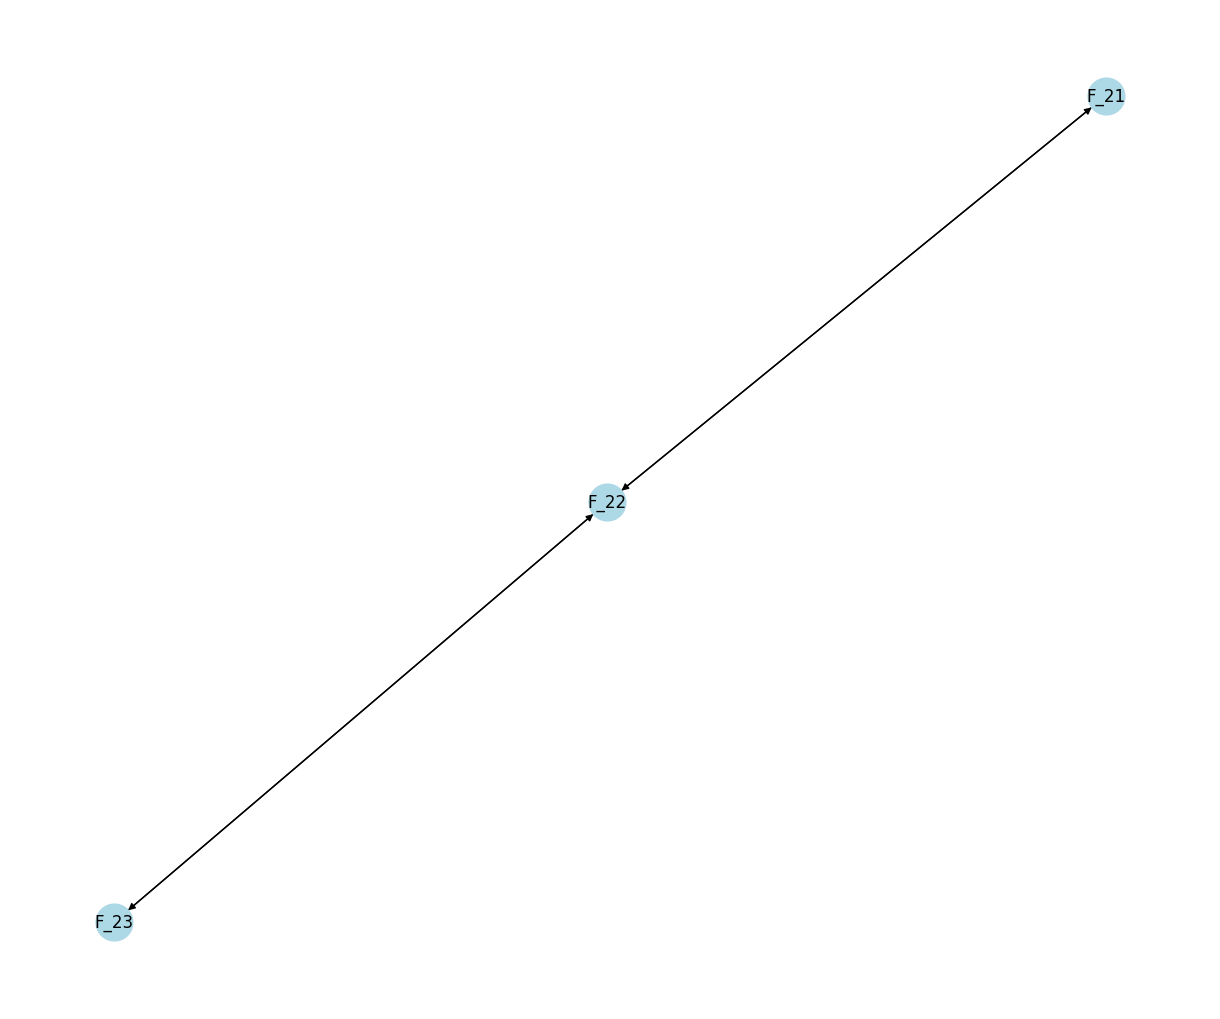

In [6]:
print(filePath)
G1 = model_to_graph(filePath)

plt.figure(figsize=(12, 10))

# Располагаем узлы для визуализации
pos = nx.kamada_kawai_layout(G1)#arf_layout(G)# spring_layout(G, seed=442)  # Автоматическое распределение узлов для логической схемы

# Выделяем узлы разного типа цветом
face_nodes = [node for node, data in G1.nodes(data=True) if data["type"] == "face"]

nx.draw(G1, pos,with_labels=True, nodelist=face_nodes, node_color="lightblue", node_size=700)

plt.axis("off")
plt.show()

In [33]:
import torch_geometric
from torch_geometric.utils import from_networkx

def graph_to_data(G: nx.Graph, label: int = None) -> torch_geometric.data.Data:
    # 1. Метрика для каждого узла
    degrees = [val for _, val in G.degree()]
    closeness = list(nx.closeness_centrality(G).values())
    betweenness = list(nx.betweenness_centrality(G).values())
    pagerank = list(nx.pagerank(G).values())
    eccentricity = list(nx.eccentricity(G).values())
    
    # 2. Собираем признаки в матрицу [num_nodes x num_features]
    features = torch.tensor(
        [[d, c, b, p, e] for d, c, b, p, e in zip(degrees, closeness, betweenness, pagerank, eccentricity)],
        dtype=torch.float
    )

    # 3. Преобразуем в PyG формат
    data = from_networkx(G)

    # 4. Добавляем признаки и метку
    data.x = features
    if label:
        data.y = torch.tensor([label], dtype=torch.long)

    return data

In [16]:
from pandas import read_csv
dataset = []
df_path = os.getcwd() + "\\filesK\\dataset.csv"
df = read_csv(df_path)
for idx, row in df.iterrows():
    filename = row["filename"]
    label = row["label"]
    filepath = os.path.join(os.getcwd() + "\\filesK", filename)
    G = model_to_graph(filepath)
    dataset.append(graph_to_data(G, label))

        

In [17]:
dataset

[Data(edge_index=[2, 4], type=[3], num_nodes=3, x=[3, 5], y=[1]),
 Data(edge_index=[2, 8], type=[5], num_nodes=5, x=[5, 5], y=[1]),
 Data(edge_index=[2, 4], type=[3], num_nodes=3, x=[3, 5], y=[1]),
 Data(edge_index=[2, 8], type=[4], num_nodes=4, x=[4, 5], y=[1]),
 Data(edge_index=[2, 4], type=[3], num_nodes=3, x=[3, 5], y=[1]),
 Data(edge_index=[2, 4], type=[3], num_nodes=3, x=[3, 5], y=[1]),
 Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5], y=[1]),
 Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5], y=[1]),
 Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5], y=[1]),
 Data(edge_index=[2, 48], type=[10], num_nodes=10, x=[10, 5], y=[1]),
 Data(edge_index=[2, 40], type=[10], num_nodes=10, x=[10, 5], y=[1]),
 Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5], y=[1]),
 Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5], y=[1]),
 Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5], y=[1]),
 Data(edge_index=[2, 24], type=[6], num_nodes=6, x=[6, 5], y=[

In [18]:
from torch_geometric.loader import DataLoader

loader = DataLoader(dataset, batch_size=8, shuffle=True)

In [19]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = torch.nn.Linear(hidden_channels, num_classes)

    def forward(self, x, edge_index, batch):
        # x — признаки узлов
        # edge_index — связи
        # batch — какой узел к какому графу относится

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        # Агрегация признаков всех узлов в один вектор на граф
        x = global_mean_pool(x, batch)

        x = self.lin(x)
        return x
    


In [20]:
model = GNN(in_channels=5, hidden_channels=64, num_classes=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [21]:
# цикл обучения
for epoch in range(1, 300):
    model.train()
    total_loss = 0

    for data in loader:  # один батч (несколько графов)
        optimizer.zero_grad()
        out = model(data.x, data.edge_index, data.batch)  # data.batch нужен для глобального пула
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 40 == 0:
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

Epoch 40, Loss: 0.0004
Epoch 80, Loss: 0.0002
Epoch 120, Loss: 0.0001
Epoch 160, Loss: 0.0001
Epoch 200, Loss: 0.0000
Epoch 240, Loss: 0.0000
Epoch 280, Loss: 0.0000


In [36]:
testFilePath = os.getcwd() + "\\filesK\\cube_test.m3d"
data = model_to_graph(testFilePath)
test_graph = graph_to_data(data)

with torch.no_grad():
    out = model(test_graph.x, test_graph.edge_index, test_graph.batch)
    pred_class = out.mean(dim=0).argmax().item()  # среднее по всем узлам
    print(f"Предсказанный класс: {pred_class}")

Предсказанный класс: 1


In [44]:
s = face.GetDefinition()
s = s.GetSurface()
s.GetEdgesCount(0)

4

In [ ]:
surface = face.GetSurface()
connected = face.ConnectedFaceCollection()
Sq = surface.GetArea(1) # площадь 1 - мм, 3 - м
Borders = surface.BoundaryCount # кол-во контуров
Edges = surface.GetEdgesCount(0) # кол-во ребер в цикле (№цикла)
Box = surface.GetGabarit() # габаритный блок,:: успех, x,y,z1, x,y,z2
NormalVec = surface.GetNormal (0,0) #успех, xyz ветора нормали в заданном U,V
#surface.GetParamVMax() получить min max U,V
Type = surface.GetSurfaceParam() # тип поверхности с интерфейсом
ClosedV = surface.IsClosedV() #замкнутость по U, V
ClosedU = surface.IsClosedU()
print(surface.IsClosedU(),surface.IsClosedV()) 
#print(connected)
c = 0
#print(connected.GetCount())
for c in range(connected.GetCount()):
    conFace = connected.GetByIndex (c)
    print (conFace.GetEntity().name )
else:
    print("no connected")
    l = 0

NameError: name 'face' is not defined